This first report of the lyrics dataset will be an exploration of the dataset and it will contain:

1. [Input data description and overview](#Input_data_description_and_overview)
2. [Data processing steps and methods](#Data_processing_steps_and_methods)
3. [Data exploration](#Data_exploration)
4. [Next steps](#Next_steps)

After understanding the data and preprocessing it to contain useful features, I will use analytical approach to find some dependencies or correlations to be able create a meaningful model based on my findings in the next report.

## Input data description and overview

The lyrics dataset contains popular songs with lyrics. There are six columns: id, song name, year of publishing, interpret name, assigned genre and the lyrics. Some rows are music composition without lyrics. There are hyphens instead of spaces
in names of songs and interprets. The only numeric column is `year`, while the others are strings and will be treated as categorical variables.

In this section, we will present a snapshot of the dataset and delve into its fundamental characteristics before proceeding with further processing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib.colors import ListedColormap
from IPython.display import display, HTML

df = pd.read_csv(
    "lyrics/lyrics.csv",
    index_col=0,
    names=["song_name", "year", "interpreter", "genre", "lyrics"],
)
# Set the default maximum width of columns
pd.set_option("display.max_colwidth", 100)
df

,song_name,year,interpreter,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut right to the chase Some women were made but me, m..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem so sure. still your ways, you dont see i'm not su..."
2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to find You can have the love You need to live But if...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a book about where we stand Then the title of my bo..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's popping no sitting around, I see you looking you loo..."
...,...,...,...,...,...
362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say Boy, after only just a couple of dates You're hands down, outright blowing my mind I..."
362233,liar,2012,edens-edge,Country,I helped you find her diamond ring You made me try it on and everything Tomorrow you'll both say...
362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth Looks a lot like me and you She's looking out at the wind...
362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth And I'm measured up by depth and girth The Father says now what...


In [2]:
%load_ext pretty_jupyter

In [3]:
total_songs = len(df)
songs_with_lyrics = df["lyrics"].count()

In [4]:
%%jmd

The dataset contains {{ total_songs }} songs, but only {{ songs_with_lyrics }} of them contain any lyrics. This means that it is quite big data (it is one of the largest datasets), especially after featurization of the text. Therefore, I will be doing basic analysis using all samples, but some analyses and modelling will be done only using the songs containing lyrics.

Next, you can see a few charts showing the distribution of values in individual columns. For better readability, I have replaced "-" in song and interpreter names with spaces and capitalized first letters.


The dataset contains 362237 songs, but only 266557 of them contain any lyrics. This means that it is quite big data (it is one of the largest datasets), especially after featurization of the text. Therefore, I will be doing basic analysis using all samples, but some analyses and modelling will be done only using the songs containing lyrics.

Next, you can see a few charts showing the distribution of values in individual columns. For better readability, I have replaced "-" in song and interpreter names with spaces and capitalized first letters.

In [5]:
df["interpreter"] = df["interpreter"].str.replace("-", " ").str.title()
df["song_name"] = df["song_name"].str.replace("-", " ").str.title()

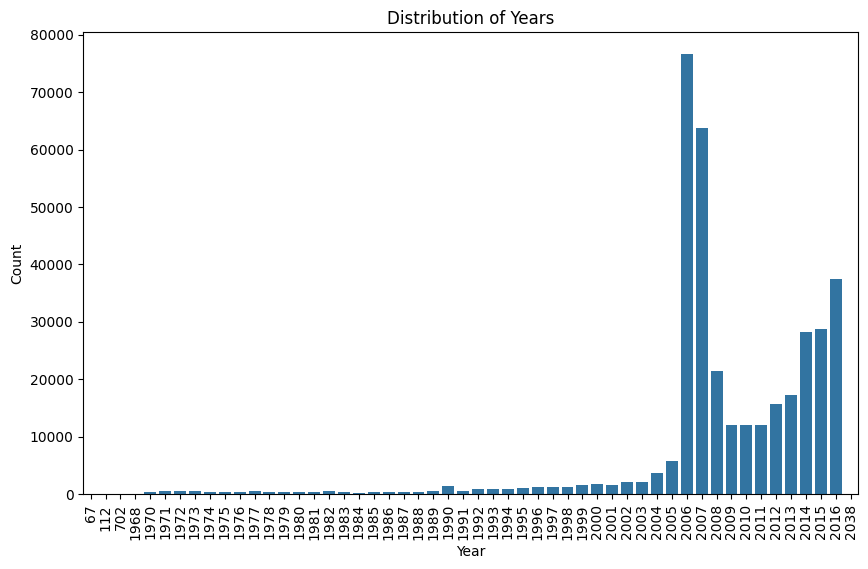

In [6]:
year_counts = df["year"].value_counts().sort_index().reset_index()
year_counts.columns = ["Year", "Count"]
plt.figure(figsize=(10, 6))
sns.barplot(x="Year", y="Count", data=year_counts)
plt.title("Distribution of Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

We can see the distribution of individual years in the first chart. We can see that most songs were published in 2006 or 2007, so we should be aware that the results reflect rather just the specific culture of those times.

The table also suggests that there might be some data quality issues regarding the release year since there are 10 songs with the year 2038 and are also a few from a distant past.

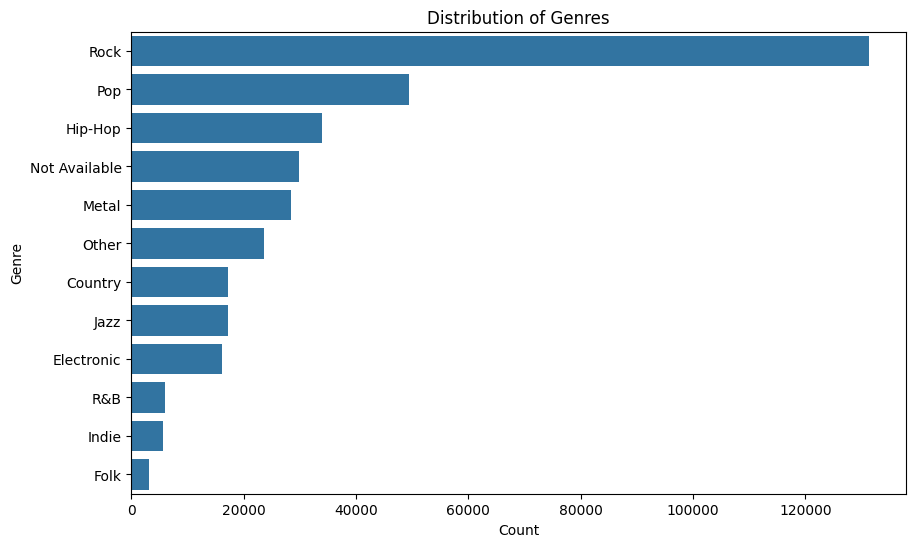

In [7]:
genre_counts = df["genre"].value_counts().reset_index()
genre_counts.columns = ["Genre", "Count"]
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Genre", data=genre_counts)
plt.title("Distribution of Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

In [8]:
genre_not_available_count = (df['genre'] == 'Not Available').sum()
genre_other_count = (df['genre'] == 'Other').sum()
num_unique_interpreters = df["interpreter"].nunique()

In [9]:
%%jmd

In the second chart, we can see the distribution of genres. The dataset is quite biased with its genre representation, so the results cannot be easily generalized to all music. We also have {{genre_not_available_count}} songs where the genre is not available and {{genre_other_count}} songs where the genre is labeled as "Other".


In the second chart, we can see the distribution of genres. The dataset is quite biased with its genre representation, so the results cannot be easily generalized to all music. We also have 29814 songs where the genre is not available and 23683 songs where the genre is labeled as "Other".

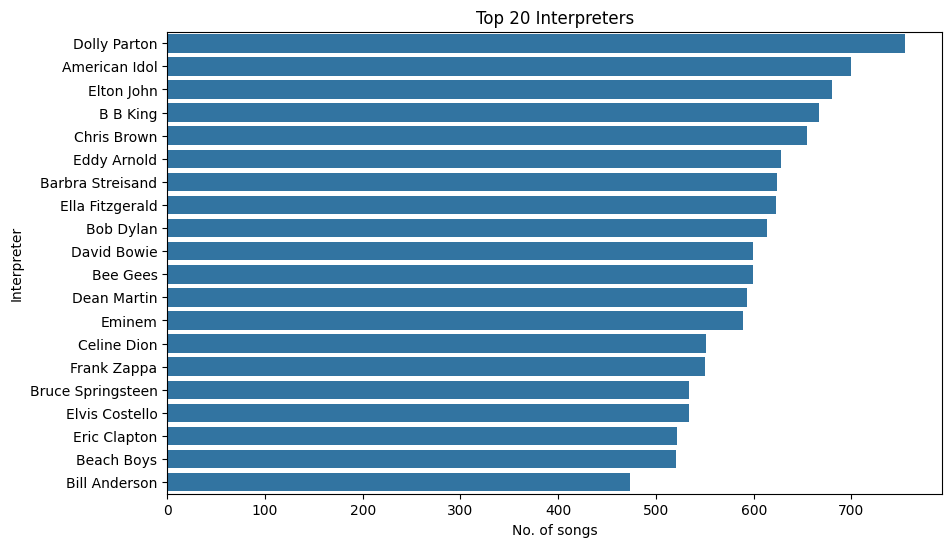

In [10]:
interpreter_counts = df["interpreter"].value_counts().reset_index()
interpreter_counts.columns = ["Interpreter", "No. of songs"]
fewest_songs = interpreter_counts["No. of songs"].value_counts().reset_index().sort_values('No. of songs', ascending=True)
fewest_songs.rename(columns={"count": "No. of interpreters"}, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x="No. of songs", y="Interpreter", data=interpreter_counts.head(20))
plt.title("Top 20 Interpreters")
plt.xlabel("No. of songs")
plt.ylabel("Interpreter")
plt.show()

In [11]:
%%jmd

The last chart from this section shows the number of songs of the top 20 interpreters based on their song count. There are {{num_unique_interpreters}} unique interpreters in the dataset, so we coudn't show all of them.

Although there are many interpreters and there are many that have a lot of songs, there are also {{fewest_songs.loc[0, 'No. of interpreters']}} that only have one song and {{fewest_songs.loc[1, 'No. of interpreters']}} of them only have two songs as we can see in the following table.


The last chart from this section shows the number of songs of the top 20 interpreters based on their song count. There are 18231 unique interpreters in the dataset, so we coudn't show all of them.

Although there are many interpreters and there are many that have a lot of songs, there are also 4514 that only have one song and 1388 of them only have two songs as we can see in the following table.

In [12]:
display(HTML(fewest_songs.head(10).to_html(index=False)))

No. of songs,No. of interpreters
1,4514
2,1388
3,832
4,600
5,490
6,450
7,421
8,475
9,503
10,763


## Data processing steps and methods

We have already made the first processing step of replacing hyphens with spaces and capitalizing first results. Now we need to take care of data quality issues and then featurize the song lyrics.

### 1. Data quality
Some of the most frequent data quality issues are null values, duplicates, inconsistencies or outliers. I have found no duplicate rows in the dataset. But we have discovered a few data quality issues in the first part - missing lyrics and release years in distant past or in the future. So first, we will have a look at columns with null values.

In [13]:
null_counts = df.isnull().sum()

In [14]:
%%jmd

There are {{null_counts['lyrics']}} songs with missing lyrics. For the first analysis, we will just impute empty strings `""` in those fields.

There are also {{null_counts['song_name']}} songs with missing `song_name`. We can see these rows in the table below.


There are 95680 songs with missing lyrics. For the first analysis, we will just impute empty strings `""` in those fields.

There are also 2 songs with missing `song_name`. We can see these rows in the table below.

In [15]:
null_song_name = df[df["song_name"].isnull()]
display(null_song_name)

,song_name,year,interpreter,genre,lyrics
193957,NaN,2009,Booker T And The Mg S,Jazz,"All right people, the rest of the hard working All star blues brothers are gonna be out here in ..."
325992,NaN,2009,Booker T,Jazz,NaN


These songs seem to be mistakes, so we can drop them.

We can notice from this table that some interpreters can sometimes collaborate with others so we need to be careful that they might also be present in other interpreter names.

Next, we will have a look at rows with suspicious release years.

In [16]:
df = df.dropna(subset=["song_name"])
df = df.fillna("")

In [17]:
display(df[(df["year"] <= 1960) | (df["year"] >= 2023)])
df = df[(df["year"] > 1960) & (df["year"] < 2023)]

,song_name,year,interpreter,genre,lyrics
27657,Star,702,Clipse,Hip-Hop,You're my star It's such a wonder how you shine So no matter how far I'm dancing with you in my ...
69708,Anywhere Remix,112,Dru Hill,Hip-Hop,"Here we are all alone You and me, privacy And we can do anything Your fantasy I wanna make your ..."
112159,Atchim,2038,Anita,Rock,
112160,O Areias,2038,Anita,Rock,
112161,Era Uma Vez Um Cavalo,2038,Anita,Rock,
112162,Anita,2038,Anita,Rock,
112163,Todos Os Patinhos,2038,Anita,Rock,
112164,Joana Come A Papa,2038,Anita,Rock,
112165,Atirei O Pau Ao Gato,2038,Anita,Rock,
112166,Eu Vi Um Sapo,2038,Anita,Rock,


These rows also seem to be errors. Since we have enough samples, we can also exclude these rows from the dataset. 

This table revealed another data quality issue - in song names, abbreviations like let's or can't are written the same way as if there were spaces instead of apostrophes. However, this should not be much of a problem since it is consistent between interpreters and song name so we will leave it as is.

Looking at the data also reveals that not all songs are in English. For example the following interpreter sings in German. We will need to take this into consideration when creating a model since creating a single model determining interpreter or genre out of lyrics will be greatly influenced by the language of the song. However, we will not adjust the data for this yet.

In [18]:
df[df["interpreter"] == "Daliah Lavi"].head(5)

,song_name,year,interpreter,genre,lyrics
385,Wer Liebe Sucht,2006,Daliah Lavi,Not Available,Ist das so schwer ein kleines Lächeln wenn du fühlst ein Mann gefällt dir sehr? Dann ist am Aben...
386,Es Geht Auch So,2006,Daliah Lavi,Not Available,Der Weg den du und ich gegangen führt mit einem Mal in's graue Niemandsland wann hat es angefang...
387,Liebeslied Jener Sommernacht,2006,Daliah Lavi,Not Available,Rote Schatten warf das Feuer hell wie Gold war der Tokayer als ein Fremder plötzlich vor mir sta...
388,Willst Du Mit Mir Gehn,2006,Daliah Lavi,Not Available,"Willst Du mit mir gehn,Wenn mein Weg in Dunkel führt. Willst Du mit mir gehn, Wenn mein Tag scho..."
389,Meine Art Liebe Zu Zeigen,2006,Daliah Lavi,Not Available,Meine Art Liebe zu zeigen das ist ganz einfach Schweigen. Worte zerstören wo sie nicht hingehöre...


There are also inconsistencies in song lyrics and the style in which they are written. Some contain spelling mistakes, but there is not much we can do about that. We could see in the above tables that some lyrics contain parts like "Verse 1:" or "[Chorus]". This would be useful if it was everywhere, but since it is not, it would be better to remove them. We will remove all parts in [] brackets and add "Chorus" and "Verse" to stopwords used when making a model.

Deeper investigation reveals that there are also phrases like "(instrumental)", "(guitar, vocals)", "(x6)", etc. Although things in regular brackets can be relevant and mostly they are some background chorus, there is a lot of noise inside them and their appearance depends on the style of the person who wrote the lyrics rather than on the actual lyrics, so we will remove them as well.

In [19]:
df["lyrics"] = df["lyrics"].str.replace(r"\[.*?\]", "", regex=True)
df["lyrics"] = df["lyrics"].str.replace(r"\(.*?\)", "", regex=True)

In [20]:
def is_same(name1, name2):
    set1 = set(name1.split())
    set2 = set(name2.split())
    if set1 == set2:
        return True    
    return False

interpreters = df['interpreter'].unique().tolist()

interpreter_mapping={}
for first in interpreters:
    for second in interpreters:
        if first != second and is_same(first, second) and len(first) <= len(second):
            if not second in interpreter_mapping:
                if not first in interpreter_mapping:
                    interpreter_mapping[second] = first
                else:
                    if interpreter_mapping[first] != second:
                        interpreter_mapping[second] = interpreter_mapping[first]
            else:
                if not first in interpreter_mapping:
                    if not second in interpreter_mapping:
                        interpreter_mapping[first] = second
                    else:
                        if interpreter_mapping[second] != first:
                            interpreter_mapping[first] = interpreter_mapping[second]

In [21]:
df['interpreter'] = df['interpreter'].replace(interpreter_mapping)

Other data quality issues revealed include for example having the song names instead of lyrics or other non-lyrics parts such as names of people who sing the part.

Because of complexity, we will not address these issues now, however it would be beneficial to address them for business usage of the dataset.

Also, although there are no duplicated rows, some songs can be present multiple times in different versions. There are many song names that appear multiple times, but only some of them are remakes. Some authors can also be present under multiple names.

See some examples of these issues below.

In [22]:
display(df[(df['song_name']=="Loving A Woman") | ((df['song_name']=="Deja Vu") & (df["interpreter"].str.contains("Beyonce")))])

,song_name,year,interpreter,genre,lyrics
151,Deja Vu,2006,Beyonce Knowles,Pop,Beyonce: Bass Jay-Z: Uh Beyonce: Hi hat Jay-Z: Uh Beyonce: 808 Jay-Z: Uh Beyonce: Jay Jay-Z: Uh-...
188,Loving A Woman,2011,Beyonce Knowles,Pop,Beyonce Knowles ft. Mary J. Blige - Loving A Woman
257431,Deja Vu,2015,Beyonce,Pop,Bass Uh Hi hat Uh 808 Uh Jay Uh huh Ready? Uh huh Let's go get 'em Uh huh Come on I used to run ...


Since the ultimate goal is to be able to classify interpreters, it will be best to have less interpreter names, so I decided to try to find similar interpreter names and replace them with the same value. As the first step, I went through all interpreter names and found those that have the same words in the name, just in a different order, and  unified them.

Then there are also many songs that are present multiple times - sometimes as remakes, sometimes instrumental versions etc. Since we have a very large dataset, it would be better to get rid of them. It also gives us a chance to reveal more interpreters that are present multiple times under different names. So I found all songs with the same name and genre and decided which of them are by the same interpreter based on fuzzywuzzy similarity score of the interpreters. Then I unified interpreter names across the dataset and kept only the version with the lyrics, and when there were more of them, only the oldest one. If it still was a tie, I chose the one with longer lyrics.

This method does many mistakes (it can change the name of one interpreter to a different one) and if we were to productionalize the dataset, it would need to be taken care of more carefully. But based on our purposes I think we will gain more value from having fewer interpreters than we would have from being 100 % accurate.

In [23]:
from fuzzywuzzy import fuzz

# threshold is defined so that Beyonce and Beyonce Knowles are similar enough
threshold = 63
grouped = df.groupby(['song_name', 'genre'])
interpreter_mapping={}
for name, group in grouped:
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            interpreter_score = fuzz.ratio(group.iloc[i]['interpreter'], group.iloc[j]['interpreter'])
            if (interpreter_score > threshold):
                first=group.iloc[i]['interpreter']
                second=group.iloc[j]['interpreter']
                if first != second:
                    if len(first) < len(second):
                        if not second in interpreter_mapping:
                            if not first in interpreter_mapping:
                                interpreter_mapping[second] = first
                            else:
                                interpreter_mapping[second] = interpreter_mapping[first]
                    else:
                        if not first in interpreter_mapping:
                            if not second in interpreter_mapping:
                                interpreter_mapping[first] = second
                            else:
                                interpreter_mapping[first] = interpreter_mapping[second]

c:\Users\elisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
df['interpreter'] = df['interpreter'].replace(interpreter_mapping)

In [25]:
df['lyrics_length'] = df['lyrics'].str.len()
df['has_lyrics'] = df['lyrics'].apply(lambda x: 1 if x != '' else 0)
df = df.sort_values(['has_lyrics', 'year', 'lyrics_length'], ascending=[False, True, False])

df = df.drop_duplicates(subset=['song_name', 'interpreter'], keep='first')

df = df.drop(columns=['lyrics_length', 'has_lyrics'])

### 2. Featurization

Since words cannot be used for modelling as they are, we will need to create some features to be able to analyze them further. We will come back again to featurization in modelling stage since right now I cannot be sure which features we will need. But for exploration, I will create the following features:
- Word count: the total number of words in the lyrics
- Unique word count: the number of unique words in the lyrics
- Average word length: the average length of the words in the lyrics
- Word frequencies (TF-IDF featurization will be used in modelling, however, it is not so good for exploration purposes)

In [26]:
df["word_count"] = df["lyrics"].apply(lambda x: len(str(x).split()))

df["unique_word_count"] = df["lyrics"].apply(lambda x: len(set(str(x).split())))

# df['average_word_length'] = df['lyrics'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0)
df["average_word_length"] = df["lyrics"].apply(
    lambda x: np.mean([len(word) for word in x.split() if word])
)

c:\Users\elisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\elisk\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
df["word_count_per_genre"] = df.groupby("genre")["word_count"].transform("mean")

df["word_count_per_interpreter"] = df.groupby("interpreter")["word_count"].transform(
    "mean"
)

df["unique_word_count_per_genre"] = df.groupby("genre")["unique_word_count"].transform(
    "mean"
)

df["unique_word_count_per_interpreter"] = df.groupby("interpreter")[
    "unique_word_count"
].transform("mean")

df["average_word_length_per_genre"] = df.groupby("genre")[
    "average_word_length"
].transform("mean")

df["average_word_length_per_interpreter"] = df.groupby("interpreter")[
    "average_word_length"
].transform("mean")

## Data exploration

### 1. Word count and length

Now we will examine our created features. The following table shows some basic statistic values of the distribution of word count, unique word count and average word length.

In [28]:
generated_columns = df[
    ["word_count", "unique_word_count", "average_word_length"]
]

summary = generated_columns.describe().drop("count")
display(summary)

,word_count,unique_word_count,average_word_length
mean,162.959106,78.14355,4.133915
std,162.983103,75.13068,1.014391
min,0.000000,0.00000,1.000000
25%,0.000000,0.00000,3.803150
50%,145.000000,76.00000,4.005952
75%,236.000000,109.00000,4.252688
max,7893.000000,2732.00000,78.000000


On the following chart, you can see the distribution of word count in the dataset. There are many songs that have no words as already stated, but most songs have around 200 words. However, there are also many outliers with over a thousand words that were hidden in the chart.

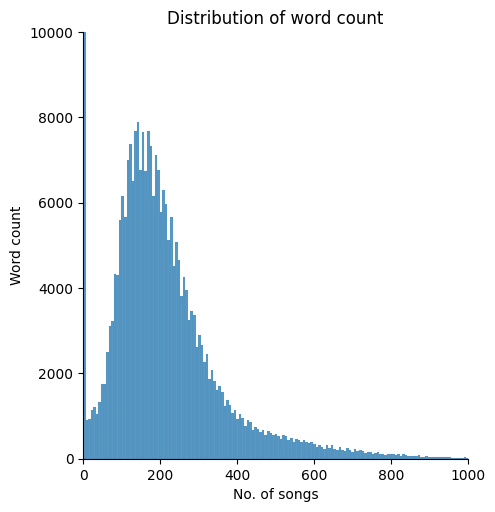

In [29]:
sns.displot(df["word_count"])
plt.xlim([0, 1000])
plt.ylim([0, 10000])
plt.xlabel("No. of songs")
plt.ylabel("Word count")
plt.title("Distribution of word count")
plt.show()

The following boxplot shows the distribution of wordcount and unique word count in different genres. Again, some outliers have been hidden since they would make the chart difficult to read. The red triange is the mean value.

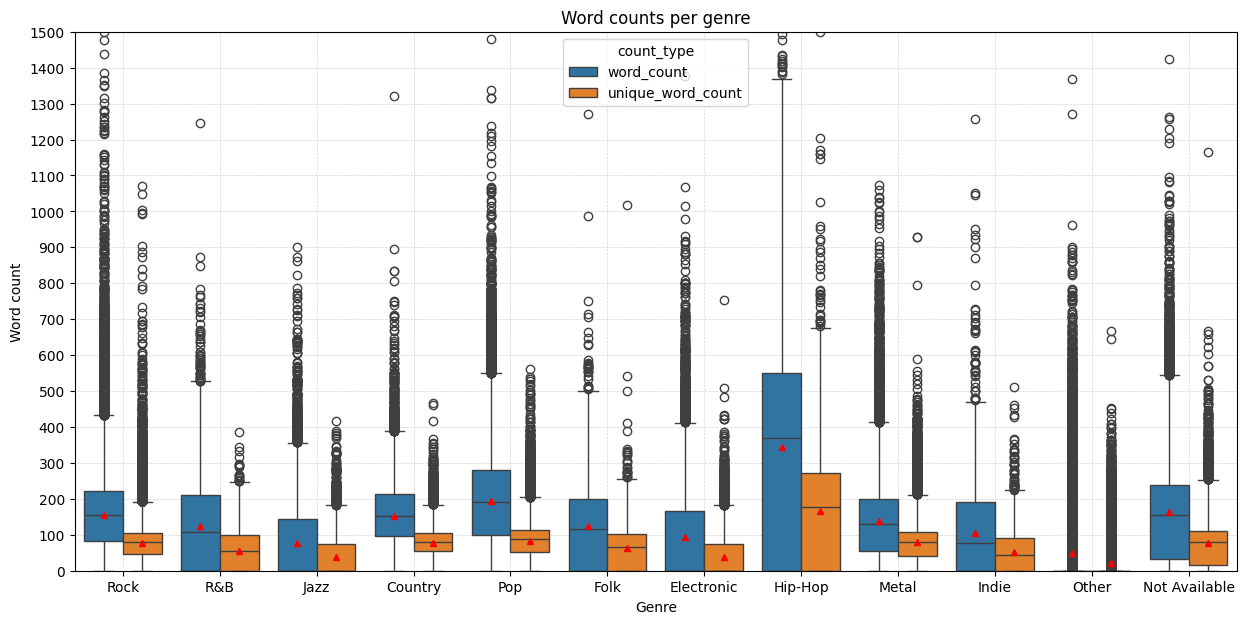

In [30]:
plt.figure(figsize=(15, 7))
melted_df = df.melt(
    id_vars="genre",
    value_vars=["word_count", "unique_word_count"],
    var_name="count_type",
    value_name="count",
)
unique_genres = [
    genre for genre in df["genre"].unique() if genre not in ["Other", "Not Available"]
]
genre_order = unique_genres + ["Other", "Not Available"]
box_plot = sns.boxplot(
    x="genre",
    y="count",
    hue="count_type",
    data=melted_df,
    order=genre_order,
    showmeans=True,
    meanprops={"markerfacecolor": "red", "markeredgecolor": "red", "markersize": "5"},
)
means = melted_df.groupby(["genre", "count_type"])["count"].mean().reset_index()
plt.title("Word counts per genre")
plt.ylim([0, 1500])
box_plot.yaxis.set_ticks(np.linspace(0, 1500, num=16))
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.ylabel("Word count")
plt.xlabel("Genre")
plt.show()

This plot seems to contain a lot of useful information. For example, we can see that there are genres that are very rarely without lyrics as well as genres that very often have no lyrics. Above all, songs labeled as "Other" rarely have any lyrics. Jazz and Electronic have at least half of their songs with no lyrics. Hip-Hop also has many songs with no lyrics, however, on average, it has the highest amount of words as well as unique words. Although there are many words in pop, there are not many unique ones.

Not Available will probably not be a very useful category since it just seems to be an average case.

The following chart shows the same information per interpreter. It shows information for 50 interpreters with the highest number of songs.

C:\Users\elisk\AppData\Local\Temp\ipykernel_28628\2620630413.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


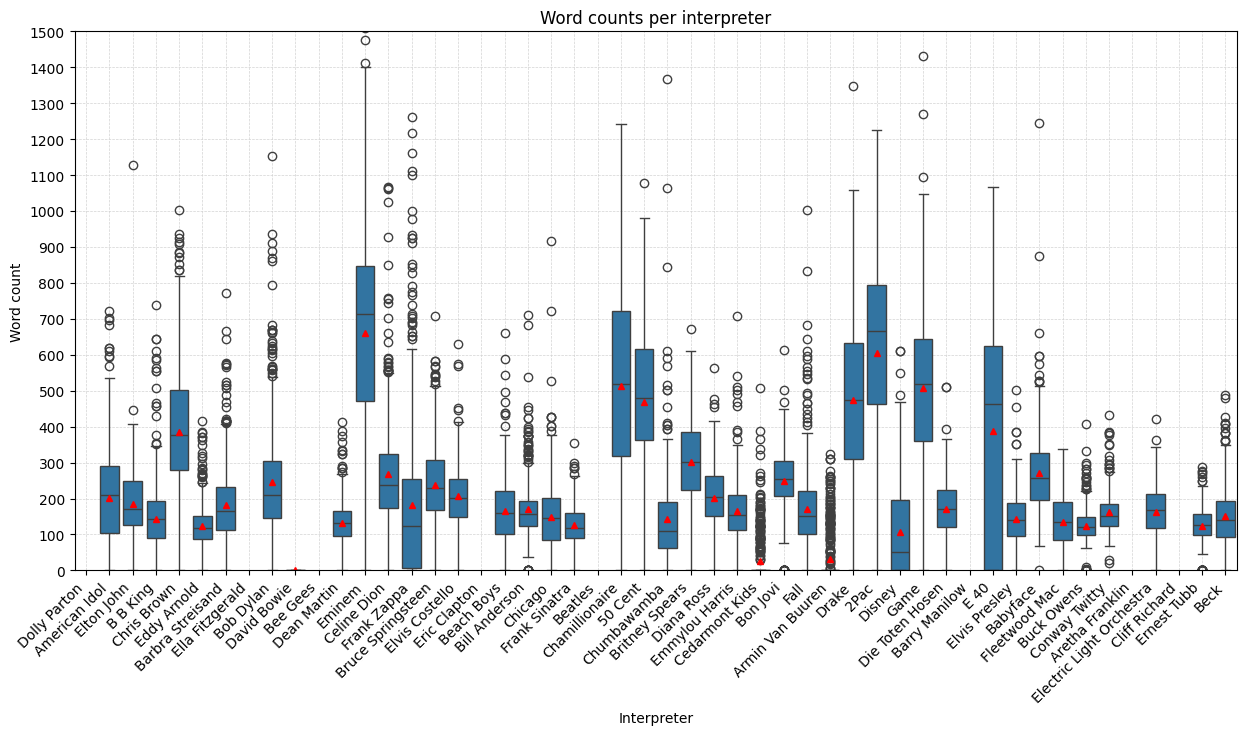

In [31]:
plt.figure(figsize=(15, 7))
top_50_interpreters = interpreter_counts.head(50)['Interpreter'].tolist()
box_plot = sns.boxplot(
    x="interpreter",
    y="word_count",
    data=df[df['interpreter'].isin(top_50_interpreters)],
    order=top_50_interpreters,
    showmeans=True,
    meanprops={"markerfacecolor": "red", "markeredgecolor": "red", "markersize": "5"},
)
plt.title("Word counts per interpreter")
plt.ylim([0, 1500])
box_plot.yaxis.set_ticks(np.linspace(0, 1500, num=16))
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.xlabel("Interpreter")
plt.ylabel("Word count")
plt.show()

Next, we can see the length of words in the lyrics. This information can be quite biased by lyrics quality, but it could still give us some useful information.

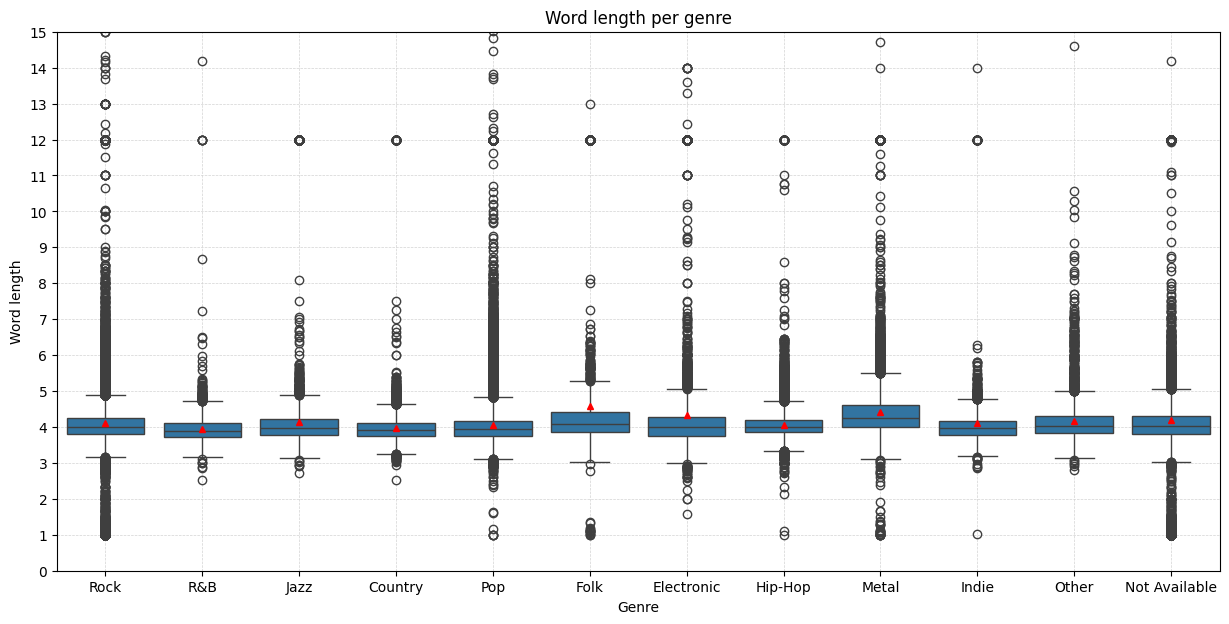

In [32]:
plt.figure(figsize=(15, 7))
box_plot = sns.boxplot(
    x="genre",
    y="average_word_length",
    data=df,
    order=genre_order,
    showmeans=True,
    meanprops={"markerfacecolor": "red", "markeredgecolor": "red", "markersize": "5"},
)
plt.title("Word length per genre")
plt.ylim([0, 15])
box_plot.yaxis.set_ticks(np.linspace(0, 15, num=16))
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.xlabel("Genre")
plt.ylabel("Word length")
plt.show()

C:\Users\elisk\AppData\Local\Temp\ipykernel_28628\506642069.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


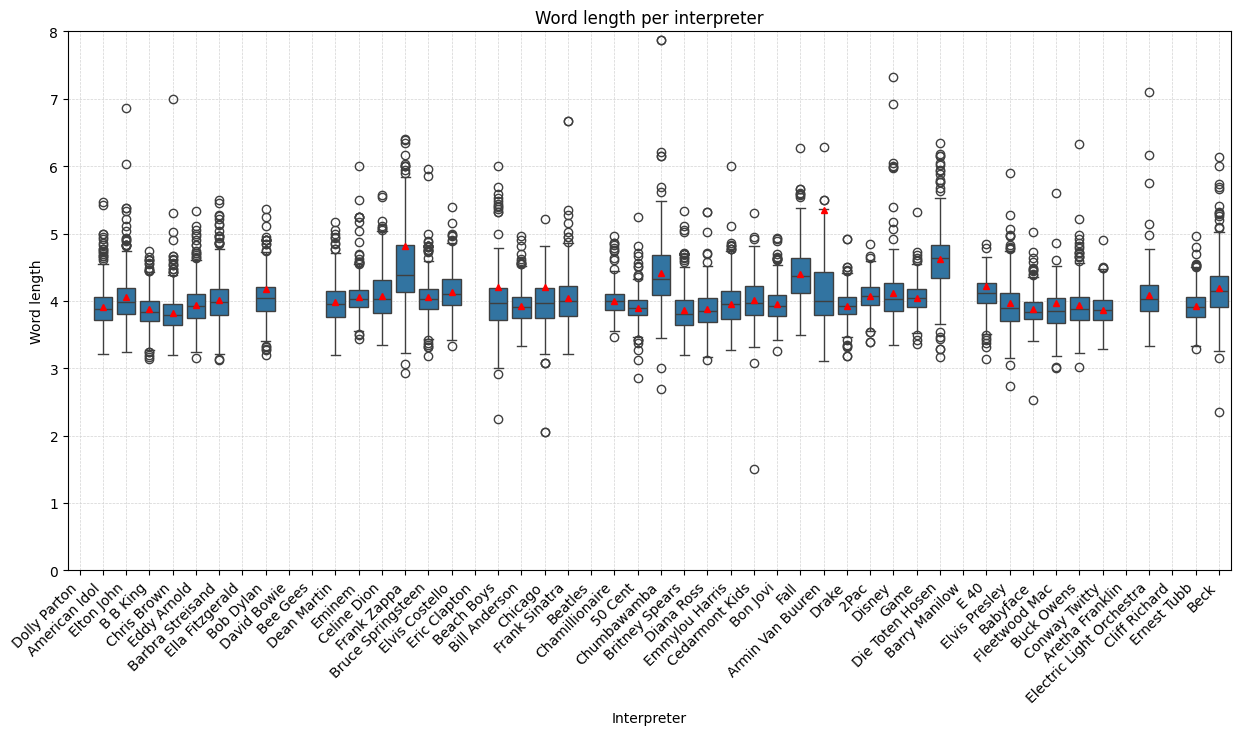

In [33]:
plt.figure(figsize=(15, 7))
box_plot = sns.boxplot(
    x="interpreter",
    y="average_word_length",
    data=df[df['interpreter'].isin(top_50_interpreters)],
    order=top_50_interpreters,
    showmeans=True,
    meanprops={"markerfacecolor": "red", "markeredgecolor": "red", "markersize": "5"},
)
plt.title("Word length per interpreter")
plt.ylim([0, 8])
box_plot.yaxis.set_ticks(np.linspace(0, 8, num=9))
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.grid(color="lightgray", linestyle="--", linewidth=0.5)
plt.xlabel("Interpreter")
plt.ylabel("Word length")
plt.show()

Word length does not differ very much between genres and interpreters. Generally Metal has the longest words and also the largest variance. One explanation that comes to my mind is that it might often be in a different language, but we can come back to this hypothesis in modelling stage. The word length is mostly around 4.

There are a few interpreters whose word length is different from the mean. However, my investigation revealed that it is really most likely because of the style in which the lyrics are written. We can sometiomes see words in the style of "oh-oh-oh" and "oh oh oh" in other cases. That means that this feature might be sometimes a good predictor in our dataset, but it would not be a good predictor for generalizing on data from new sources.

### 2. Word frequencies

The following chart shows the frequency of individual words in the lyrics, after some basic stopwords were removed. The smaller stopwords version was used with some modifications, since in songs there can be quite a lot of meaning in otherwise meaningless words.

In [34]:
with open("stopwords.txt", "r") as f:
    stopwords = f.read().splitlines()

In [35]:
vectorizer = CountVectorizer(max_features=50, stop_words=stopwords)

word_freq = vectorizer.fit_transform(df["lyrics"])

word_freq_df_stop = pd.DataFrame(
    word_freq.toarray(), columns=vectorizer.get_feature_names_out()
)

<Axes: title={'center': 'Word frequencies in different genres'}, xlabel='Word', ylabel='No. of occurences'>

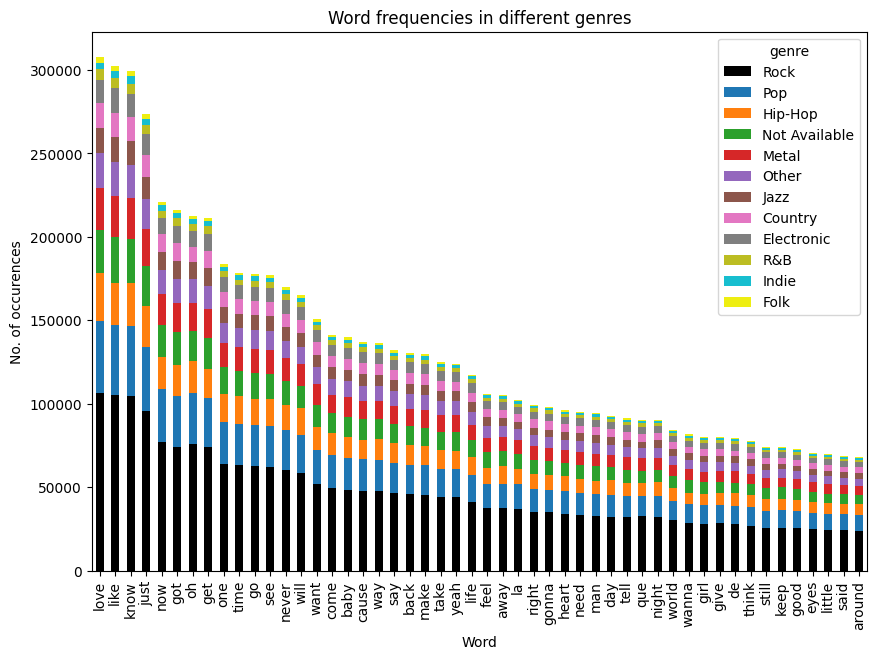

In [36]:
merged_df = pd.concat([df["genre"], word_freq_df_stop], axis=1)

word_freq_by_genre = merged_df.groupby("genre").sum()

word_freq_by_genre = word_freq_by_genre.transpose()

word_freq_by_genre = word_freq_by_genre.loc[
    word_freq_by_genre.sum(axis=1).sort_values(ascending=False).index[:100]
]

sorted_genres = word_freq_by_genre.sum().sort_values(ascending=False).index

word_freq_by_genre = word_freq_by_genre[sorted_genres]

default_colors = sns.color_palette("tab10", 10).as_hex()

extended_colors = ["#000000"] + default_colors + ["#EEEE11"]

extended_cmap = ListedColormap(extended_colors)
word_freq_by_genre.head(50).plot(
    kind="bar", stacked=True, figsize=(10, 7), colormap=extended_cmap, title="Word frequencies in different genres", xlabel="Word", ylabel="No. of occurences"
)

We can see that term frequency does not differ very much between genres. The chart also contains some spanish words like "que", "de" and "la". We can see that songs labelled as "Other" or "Not Available" might often be in Spanish based on their distribution of the word "que", as opposed to Rock which contains fewer occurences of this word. The main genre with a different word distribution is Hip-Hop with its few occurences of "love" or "away", "heart" and many occurences of "like" or "get"/"got". Otherwise the distributions are quite similar. 

### 3. Multigenre interpreters

There are 11 interpreters in the dataset that sing in two genres (after excluding Not Available). You can see them in the following table. Since it is so rare, it means that genre will be a good predictor for interpreter.

In [37]:
df=df[df["genre"] != "Not Available"]
genre_counts = df.groupby('interpreter')['genre'].nunique()

df_genre_counts = genre_counts.reset_index().rename(columns={'genre': 'genre_count'})
df_genre_counts = df_genre_counts[df_genre_counts['genre_count']>1]

genre_list = df.groupby('interpreter')['genre'].apply(set).reset_index()

df_genre = pd.merge(df_genre_counts, genre_list, on='interpreter')

df_genre[['interpreter', 'genre']]



,interpreter,genre
0,Aka,"{Rock, Other}"
1,Bow Wow,"{Rock, Hip-Hop}"
2,Cash,"{Pop, Metal}"
3,Champagne,"{Rock, Pop}"
4,Cry,"{Metal, Country}"
5,D,"{Rock, Pop}"
6,Dark,"{Indie, Rock}"
7,Evelyn,"{Rock, Electronic}"
8,Everything,"{Metal, Pop}"
9,Fats Domino,"{Rock, R&B}"


## Conclusion

We have seen some basic features and statistics of our dataset. We also cleaned our data and prepared some useful features. We have gained good understanding of our data and now we can use them in further analyses and modelling.

Based on the results, in my next report, I would like to dedicate space to the following topics:
- separating songs based on their language (either by using a library or by unsupervised clustering): this could significantly improve performance of any other model
- prediction of song genre/interpreter/year according to lyrics